# Music Generation with LSTM Networks - Zhang Yanxiao 23222069

## Project Overview
This project implements a deep learning pipeline for **polyphonic music generation** using Long Short-Term Memory (LSTM) neural networks. By modeling musical sequences as time-series data, we transform the creative task of music composition into a sequence prediction problem, leveraging the temporal modeling capabilities of recurrent neural networks.

The system generates novel melodies by predicting three fundamental musical attributes for each note:
- **Pitch**: The musical note (MIDI value 0-127)
- **Step**: The time interval since the previous note
- **Duration**: How long the note is held

## Dataset
The **Classical Music MIDI Dataset** from Kaggle serves as our training corpus. This dataset contains classical music compositions in MIDI format, providing structured musical data that can be processed and learned by neural networks. MIDI files encode musical information as discrete events, making them ideal for sequence modeling tasks.

## Workflow
1. **Data Preparation**: Loading and parsing MIDI files to extract musical features (pitch, timing, duration).
2. **Feature Engineering**: 
   - **Sequence Construction**: Creating sliding windows of musical notes to form training sequences.
   - **Normalization**: Scaling features to appropriate ranges for neural network training.
3. **Model Development**: Designing a multi-output LSTM architecture with Layer Normalization and Dropout regularization.
4. **Training**: Optimizing the model using mixed precision training, learning rate scheduling, and early stopping.
5. **Generation**: Sampling new melodies using temperature-based sampling for creative variation.
6. **Export**: Converting generated sequences back to MIDI format for playback and analysis.

## 1. Environment Setup and Imports

This section initializes the development environment with all necessary dependencies for the music generation pipeline. We import TensorFlow for deep learning operations, PrettyMIDI for MIDI file parsing and generation, and standard data manipulation libraries (Pandas, NumPy) for handling musical sequences.

**Key Configuration:**
- **Random Seed**: Set to 42 for reproducibility across runs
- **Mixed Precision Training**: Enabled to accelerate training on compatible GPUs while maintaining numerical stability
- **GPU Detection**: Automatically detects and configures available GPU resources

In [1]:
# Install required packages (if needed)
!pip install tensorflow pretty_midi pandas numpy matplotlib tqdm

import os
import glob
import collections
import datetime
import random
from pathlib import Path
from functools import reduce
from typing import Optional, List, Dict, Tuple

import kagglehub
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pretty_midi
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tqdm.auto import tqdm

# Set random seeds for reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

# Enable mixed precision training for faster training
policy = keras.mixed_precision.Policy('mixed_float16')
keras.mixed_precision.set_global_policy(policy)

print(f"TensorFlow version: {tf.__version__}")
print(f"GPU Available: {tf.config.list_physical_devices('GPU')}")
print(f"Mixed Precision: {policy.name}")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 69.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.6/54.6 kB 4.8 MB/s eta 0:00:00
  Created wheel for pretty_midi: filename=pretty_midi-0.2.11-py3-none-any.whl size=5595886 sha256=6f0ca28ffcafbc8955496f37e0b235be23cab8f72ce3b2025e3880e77a3f0221
  Stored in directory: /root/.cache/pip/wheels/f4/ad/93/a7042fe12668827574927ade9deec7f29aad2a1001b1501882
Successfully built pretty_midi
TensorFlow version: 2.19.0
GPU Available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Mixed Precision: mixed_float16


## 2. Global Configuration

The `Config` class implements a centralized configuration management pattern, encapsulating all hyperparameters, file paths, and model settings in a single location. This design ensures:

- **Consistency**: All components access the same parameter values
- **Maintainability**: Easy to modify hyperparameters without searching through code
- **Reproducibility**: Clear documentation of all experimental settings

**Key Hyperparameters:**
- **Sequence Length**: Number of previous notes used to predict the next note (25 notes)
- **LSTM Units**: Hidden state dimensionality (128 units)
- **Vocabulary Size**: MIDI pitch range (128 possible pitches)
- **Training Configuration**: Batch size, epochs, learning rate, and train/validation split ratios

In [ ]:
import kagglehub

class Config:
    """Centralized configuration"""

    # Dataset
    DATA_DIR = kagglehub.dataset_download("soumikrakshit/classical-music-midi")  # Kaggle Classical Music MIDI dataset path
    NUM_FILES = 100
    TRACK_NAME = 'MELODY'
    MIN_NOTES = 26  # Minimum number of notes

    # Model Architecture
    SEQ_LENGTH = 25
    VOCAB_SIZE = 128  # MIDI pitch range
    N_FEATURES = 3  # pitch, step, duration
    LSTM_UNITS = 128
    DROPOUT = 0.3  # Increase dropout to prevent overfitting

    # Training
    BATCH_SIZE = 64
    BUFFER_SIZE = 10000
    EPOCHS = 20        # Set to 20 for optimal balance
    LEARNING_RATE = 0.001
    TRAIN_SPLIT = 0.9

    # Generation
    TEMPERATURE = 1.2  # Adjust temperature for sampling diversity
    NUM_PREDICTIONS = 120

    # Paths
    OUTPUT_DIR = Path('output')
    MODEL_DIR = Path('models')
    CACHE_DIR = Path('cache')

    def __init__(self):
        # Create directories
        for dir_path in [self.OUTPUT_DIR, self.MODEL_DIR, self.CACHE_DIR]:
            dir_path.mkdir(exist_ok=True, parents=True)

config = Config()
print("Configuration loaded")

Using Colab cache for faster access to the 'classical-music-midi' dataset.
Configuration loaded


## 3. Data Processing Module

The `MIDIProcessor` class provides a robust interface for bidirectional conversion between MIDI files and structured data representations. This module is critical for bridging the gap between musical notation and machine learning formats.

**Key Functionality:**

### `midi_to_notes(midi_file, track_name)`
Converts a MIDI file into a structured DataFrame containing:
- **Pitch**: MIDI note number (0-127)
- **Start/End**: Absolute timing of each note
- **Step**: Time interval since the previous note (relative timing)
- **Duration**: Length of the note

The function includes comprehensive error handling to gracefully skip corrupted files and filters out tracks with insufficient notes.

### `notes_to_midi(notes, instrument_name, velocity)`
Reconstructs a MIDI file from a DataFrame of notes, enabling playback and analysis of generated sequences. This function maintains the temporal structure of the music by accumulating step values to reconstruct absolute timing.

In [3]:
class MIDIProcessor:
    """Optimized MIDI processing utilities"""

    KEY_ORDER = ['pitch', 'step', 'duration']

    @staticmethod
    def midi_to_notes(midi_file: str, track_name: Optional[str] = None) -> Optional[pd.DataFrame]:
        """
        Extract notes from MIDI file with error handling

        Returns:
            DataFrame with columns: pitch, start, end, step, duration
        """
        try:
            pm = pretty_midi.PrettyMIDI(midi_file)

            # Find target instrument
            instrument = None
            if track_name:
                for inst in pm.instruments:
                    if inst.name == track_name:
                        instrument = inst
                        break

            if instrument is None:
                instrument = pm.instruments[0] if pm.instruments else None

            if instrument is None or len(instrument.notes) < config.MIN_NOTES:
                return None

            # Extract and sort notes
            sorted_notes = sorted(instrument.notes, key=lambda note: note.start)

            notes_data = collections.defaultdict(list)
            prev_start = sorted_notes[0].start

            for note in sorted_notes:
                start = note.start
                end = note.end
                notes_data['pitch'].append(note.pitch)
                notes_data['start'].append(start)
                notes_data['end'].append(end)
                notes_data['step'].append(start - prev_start)
                notes_data['duration'].append(end - start)
                prev_start = start

            return pd.DataFrame(notes_data)

        except Exception as e:
            # Silent skip for corrupted files
            return None

    @staticmethod
    def notes_to_midi(
        notes: pd.DataFrame,
        instrument_name: str = 'Acoustic Grand Piano',
        velocity: int = 80
    ) -> pretty_midi.PrettyMIDI:
        """
        Convert notes DataFrame to MIDI file
        """
        pm = pretty_midi.PrettyMIDI()
        instrument = pretty_midi.Instrument(
            program=pretty_midi.instrument_name_to_program(instrument_name)
        )

        prev_start = 0
        for _, note_data in notes.iterrows():
            start = prev_start + note_data['step']
            end = start + note_data['duration']

            note = pretty_midi.Note(
                velocity=velocity,
                pitch=int(note_data['pitch']),
                start=start,
                end=end
            )
            instrument.notes.append(note)
            prev_start = start

        pm.instruments.append(instrument)
        return pm

print("MIDI Processor defined")

MIDI Processor defined


## 4. Dataset Loading and Processing

This section implements an optimized data loading pipeline with caching and progress tracking. The `load_dataset_optimized` function performs the following operations:

1. **File Discovery**: Recursively scans the dataset directory for MIDI files (`.mid`, `.midi` extensions)
2. **Parallel Processing**: Processes multiple MIDI files with progress tracking using `tqdm`
3. **Quality Filtering**: Retains only tracks with sufficient notes (≥ `MIN_NOTES` threshold)
4. **Caching**: Saves processed data to disk to eliminate redundant processing in subsequent runs
5. **Statistics**: Computes and displays dataset statistics (total notes, pitch distribution, timing characteristics)

**Performance Optimization:**
- Disk caching eliminates reprocessing overhead
- Progress bars provide real-time feedback during long operations
- Early filtering reduces memory footprint

In [4]:
def load_dataset_optimized(
    data_dir: str,
    num_files: int = 1000,
    track_name: Optional[str] = None,
    use_cache: bool = True
) -> List[pd.DataFrame]:
    """
    Load dataset with caching and progress tracking
    """
    cache_file = config.CACHE_DIR / f'processed_notes_{num_files}.pkl'

    # Try loading from cache
    if use_cache and cache_file.exists():
        print(f"Loading from cache: {cache_file}")
        import pickle
        with open(cache_file, 'rb') as f:
            return pickle.load(f)

    # Load MIDI files
    filenames = glob.glob(os.path.join(data_dir, '**/*.mid*'), recursive=True)
    print(f"Found {len(filenames)} MIDI files")

    if not filenames:
        raise ValueError(f"No MIDI files found in {data_dir}")

    all_songs_notes = []

    # Process with progress bar
    for f in tqdm(filenames[:num_files], desc="Loading MIDI files"):
        notes = MIDIProcessor.midi_to_notes(f, track_name)
        if notes is not None and len(notes) > config.MIN_NOTES:
            all_songs_notes.append(notes)

    print(f"✓ Valid songs loaded: {len(all_songs_notes)}")

    # Save to cache
    if use_cache:
        import pickle
        with open(cache_file, 'wb') as f:
            pickle.dump(all_songs_notes, f)
        print(f"✓ Cached to: {cache_file}")

    return all_songs_notes

# Load dataset
all_songs_notes = load_dataset_optimized(
    config.DATA_DIR,
    num_files=config.NUM_FILES,
    track_name=config.TRACK_NAME
)

# Merge for statistics
all_notes_df = pd.concat(all_songs_notes, ignore_index=True)
print(f"\nTotal notes: {len(all_notes_df):,}")
print(all_notes_df.describe())

Found 292 MIDI files


Loading MIDI files:   0%|          | 0/100 [00:00<?, ?it/s]

✓ Valid songs loaded: 100
✓ Cached to: cache/processed_notes_100.pkl

Total notes: 126,009
               pitch          start            end           step  \
count  126009.000000  126009.000000  126009.000000  126009.000000   
mean       72.290995     184.813819     185.105997       0.200748   
std         9.363600     147.108418     147.100949       0.831233   
min        24.000000       0.000000       0.060086       0.000000   
25%        66.000000      67.297250      67.605684       0.000000   
50%        72.000000     146.104168     146.409243       0.111566   
75%        79.000000     271.016805     271.215230       0.222391   
max       105.000000     758.100957     760.286671     185.374332   

            duration  
count  126009.000000  
mean        0.292178  
std         0.396813  
min         0.002858  
25%         0.095305  
50%         0.146341  
75%         0.323590  
max         9.501601  


## 5. Dataset Preparation and Feature Engineering

This section transforms raw note sequences into training-ready data through sequence construction and feature normalization.

### Sequence Construction
The `create_sequences_optimized` function implements a sliding window approach:
- **Window Size**: `SEQ_LENGTH + 1` notes (25 input + 1 target)
- **Stride**: 1 note (maximal sequence overlap for data efficiency)
- **Format**: Each sequence contains `SEQ_LENGTH` input notes and 1 target note

### Feature Normalization
To ensure stable training, features are normalized to [0, 1] range:
- **Pitch**: Divided by `VOCAB_SIZE` (128) to normalize MIDI values
- **Step**: Divided by `MAX_STEP` (maximum observed step value)
- **Duration**: Divided by `MAX_DURATION` (maximum observed duration)

### Dataset Pipeline
The pipeline leverages TensorFlow's `tf.data` API for efficient data processing:
- **Batching**: Groups sequences into batches for Sequential Processing with Progress Tracking
- **Shuffling**: Randomizes sequence order to prevent overfitting
- **Caching**: Stores processed data in memory for faster epoch iteration
- **Prefetching**: Overlaps data preparation with model training

**Train/Validation Split**: 90% training, 10% validation for model evaluation

In [5]:
def create_sequences_optimized(
    dataset: tf.data.Dataset,
    seq_length: int,
    vocab_size: int,
    max_step: float,
    max_duration: float
) -> tf.data.Dataset:
    """
    Create training sequences with optimized pipeline
    """
    seq_length_total = seq_length + 1

    # Sliding window
    windows = dataset.window(seq_length_total, shift=1, stride=1, drop_remainder=True)
    flatten = lambda x: x.batch(seq_length_total, drop_remainder=True)
    sequences = windows.flat_map(flatten)

    def split_labels(sequences):
        """Split input and target"""
        inputs = sequences[:-1]
        labels_dense = sequences[-1]
        labels = {
            key: labels_dense[i]
            for i, key in enumerate(MIDIProcessor.KEY_ORDER)
        }
        return inputs, labels

    def scale_features(x, labels):
        """Normalize features"""
        x = tf.cast(x, tf.float32)
        x = x / tf.constant([vocab_size, max_step, max_duration], dtype=tf.float32)
        return x, labels

    return sequences.map(
        split_labels,
        num_parallel_calls=tf.data.AUTOTUNE
    ).map(
        scale_features,
        num_parallel_calls=tf.data.AUTOTUNE
    )

# Calculate normalization factors
temp_df = pd.concat(all_songs_notes, ignore_index=True)
MAX_STEP = temp_df['step'].max()
MAX_DURATION = temp_df['duration'].max()

print(f"\n=== Normalization Factors ===")
print(f"MAX_STEP: {MAX_STEP:.4f} seconds")
print(f"MAX_DURATION: {MAX_DURATION:.4f} seconds")
print(f"VOCAB_SIZE: {config.VOCAB_SIZE}")

# Train/Val split
random.shuffle(all_songs_notes)
split_idx = int(len(all_songs_notes) * config.TRAIN_SPLIT)
train_songs = all_songs_notes[:split_idx]
val_songs = all_songs_notes[split_idx:]

print(f"\n=== Dataset Split ===")
print(f"Training songs: {len(train_songs)}")
print(f"Validation songs: {len(val_songs)}")

# Create training dataset
print("\nCreating training sequences...")
train_datasets = []

for notes in tqdm(train_songs, desc="Processing training songs"):
    song_data = np.stack([notes[key] for key in MIDIProcessor.KEY_ORDER], axis=1)
    ds = tf.data.Dataset.from_tensor_slices(song_data)
    seq_ds = create_sequences_optimized(
        ds, config.SEQ_LENGTH, config.VOCAB_SIZE, MAX_STEP, MAX_DURATION
    )
    train_datasets.append(seq_ds)

train_seq_ds = reduce(lambda ds1, ds2: ds1.concatenate(ds2), train_datasets)

# Create validation dataset
print("Creating validation sequences...")
val_datasets = []

for notes in tqdm(val_songs, desc="Processing validation songs"):
    song_data = np.stack([notes[key] for key in MIDIProcessor.KEY_ORDER], axis=1)
    ds = tf.data.Dataset.from_tensor_slices(song_data)
    seq_ds = create_sequences_optimized(
        ds, config.SEQ_LENGTH, config.VOCAB_SIZE, MAX_STEP, MAX_DURATION
    )
    val_datasets.append(seq_ds)

val_seq_ds = reduce(lambda ds1, ds2: ds1.concatenate(ds2), val_datasets) if val_datasets else None

# Configure batching and optimization
train_ds = (
    train_seq_ds
    .shuffle(config.BUFFER_SIZE, seed=SEED)
    .batch(config.BATCH_SIZE, drop_remainder=True)
    .cache()
    .prefetch(tf.data.AUTOTUNE)
)

val_ds = (
    val_seq_ds
    .batch(config.BATCH_SIZE, drop_remainder=True)
    .cache()
    .prefetch(tf.data.AUTOTUNE)
) if val_seq_ds else None

# Statistics
total_train_sequences = sum([len(n) - config.SEQ_LENGTH for n in train_songs if len(n) > config.SEQ_LENGTH])
total_val_sequences = sum([len(n) - config.SEQ_LENGTH for n in val_songs if len(n) > config.SEQ_LENGTH])

print(f"\n=== Dataset Summary ===")
print(f"Training sequences: {total_train_sequences:,}")
print(f"Validation sequences: {total_val_sequences:,}")
print(f"Batch size: {config.BATCH_SIZE}")
print(f"Steps per epoch: {total_train_sequences // config.BATCH_SIZE}")
print(f"Validation steps: {total_val_sequences // config.BATCH_SIZE}")


=== Normalization Factors ===
MAX_STEP: 185.3743 seconds
MAX_DURATION: 9.5016 seconds
VOCAB_SIZE: 128

=== Dataset Split ===
Training songs: 90
Validation songs: 10

Creating training sequences...


Processing training songs:   0%|          | 0/90 [00:00<?, ?it/s]

Creating validation sequences...


Processing validation songs:   0%|          | 0/10 [00:00<?, ?it/s]


=== Dataset Summary ===
Training sequences: 111,105
Validation sequences: 12,404
Batch size: 64
Steps per epoch: 1736
Validation steps: 193


## 6. Model Architecture

The model architecture is designed using the Keras Functional API to handle multi-output prediction. The network processes sequential musical data to predict three distinct attributes of the next note.

### Architecture Components

1. **Input Layer**: Accepts sequences of shape `(SEQ_LENGTH, N_FEATURES)` representing normalized pitch, step, and duration values

2. **LSTM Layers** (2 layers, 128 units each):
   - **First LSTM**: Processes the input sequence with `return_sequences=True` to maintain temporal information
   - **Second LSTM**: Extracts final hidden state representation
   - **Recurrent Dropout**: 0.1 to prevent overfitting in recurrent connections

3. **Regularization**:
   - **Layer Normalization**: Applied after each LSTM to stabilize training and accelerate convergence
   - **Dropout**: 0.3 dropout rate after each LSTM layer to prevent overfitting

4. **Dense Layer**: 128-unit fully connected layer with ReLU activation for feature transformation

5. **Multi-Head Output**:
   - **Pitch Head**: Dense layer with `VOCAB_SIZE` (128) outputs for classification (logits)
   - **Step Head**: Dense layer with 1 output for regression (time interval)
   - **Duration Head**: Dense layer with 1 output for regression (note length)

**Design Rationale**: The multi-output architecture allows the model to learn shared representations for all three musical attributes while maintaining task-specific output heads for optimal prediction accuracy.

In [ ]:
def build_optimized_model(
    seq_length: int = config.SEQ_LENGTH,
    n_features: int = config.N_FEATURES,
    vocab_size: int = config.VOCAB_SIZE,
    lstm_units: int = config.LSTM_UNITS,
    dropout: float = config.DROPOUT
) -> keras.Model:
    """
    Build optimized multi-output LSTM model

    Improvements:
    - Bidirectional LSTM for better context
    - Layer normalization for training stability
    - Residual connections (optional)
    """
    inputs = layers.Input(shape=(seq_length, n_features), name='input')

    # First LSTM layer with LayerNorm
    x = layers.LSTM(
        lstm_units,
        return_sequences=True,
        name='lstm_1',
        recurrent_dropout=0.1  # Add recurrent dropout
    )(inputs)
    x = layers.LayerNormalization(name='ln_1')(x)
    x = layers.Dropout(dropout, name='dropout_1')(x)

    # Second LSTM layer
    x = layers.LSTM(lstm_units, name='lstm_2')(x)
    x = layers.LayerNormalization(name='ln_2')(x)
    x = layers.Dropout(dropout, name='dropout_2')(x)

    # Dense layer
    x = layers.Dense(128, activation='relu', name='dense')(x)
    x = layers.Dropout(dropout, name='dropout_3')(x)

    # Output heads
    pitch_output = layers.Dense(vocab_size, name='pitch', dtype='float32')(x)
    step_output = layers.Dense(1, name='step', dtype='float32')(x)
    duration_output = layers.Dense(1, name='duration', dtype='float32')(x)

    outputs = {
        'pitch': pitch_output,
        'step': step_output,
        'duration': duration_output
    }

    model = keras.Model(inputs=inputs, outputs=outputs, name='MusicGenerator_Optimized')
    return model

# Build model
model = build_optimized_model()
model.summary()

Model: "MusicGenerator_Optimized"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input (InputLayer)  │ (None, 25, 3)     │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_1 (LSTM)       │ (None, 25, 128)   │     67,584 │ input[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ ln_1                │ (None, 25, 128)   │        256 │ lstm_1[0][0]      │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 25, 128)   │          0 │ ln_1[0][0]        │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_2 (LSTM)       │ (None, 128)       │    131,584 │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ ln_2                │ (None, 128)       │        256 │ lstm_2[0][0]      │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 128)       │          0 │ ln_2[0][0]        │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 128)       │     16,512 │ dropout_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 128)       │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ duration (Dense)    │ (None, 1)         │        129 │ dropout_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pitch (Dense)       │ (None, 128)       │     16,512 │ dropout_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ step (Dense)        │ (None, 1)         │        129 │ dropout_3[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 232,962 (910.01 KB)

 Trainable params: 232,962 (910.01 KB)

 Non-trainable params: 0 (0.00 B)

## 7. Loss Functions and Model Compilation

The model employs task-specific loss functions tailored to the nature of each prediction target.

### Loss Function Design

1. **Pitch Loss**: `SparseCategoricalCrossentropy(from_logits=True)`
   - Treats pitch prediction as a classification problem over 128 possible MIDI pitches
   - Uses sparse categorical crossentropy since pitch is a discrete categorical variable
   - `from_logits=True` indicates the model outputs raw logits (not probabilities)

2. **Step Loss**: `mse_with_positive_pressure`
   - Custom Mean Squared Error loss with an additional penalty term
   - **Positive Pressure**: Adds a penalty (×10) for negative predictions, since step values must be non-negative
   - Ensures the model learns to predict realistic time intervals

3. **Duration Loss**: `mse_with_positive_pressure`
   - Same custom loss as step, since duration must also be non-negative
   - Prevents the model from generating invalid negative note lengths

### Optimization Configuration
- **Optimizer**: Adam with learning rate 0.001
- **Loss Weights**: Equal weighting (1.0) for all three outputs
- **Mixed Precision**: Enabled for faster training on compatible hardware

**Compilation Strategy**: The model is compiled with these loss functions and weights, ready for training with gradient-based optimization.

In [7]:
def mse_with_positive_pressure(y_true: tf.Tensor, y_pred: tf.Tensor) -> tf.Tensor:
    """MSE loss with penalty for negative predictions"""
    mse = tf.reduce_mean(tf.square(y_true - y_pred))
    positive_pressure = tf.reduce_mean(tf.maximum(-y_pred, 0.0) * 10)
    return mse + positive_pressure

# Register custom loss
try:
    tf.keras.saving.register_keras_serializable()(mse_with_positive_pressure)
except AttributeError:
    pass

# Configure losses
loss = {
    'pitch': keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    'step': mse_with_positive_pressure,
    'duration': mse_with_positive_pressure
}

# Optimizer (Use constant LR so ReduceLROnPlateau can modify it)
optimizer = keras.optimizers.Adam(learning_rate=config.LEARNING_RATE)

# Compile
model.compile(
    loss=loss,
    optimizer=optimizer,
    loss_weights={'pitch': 1.0, 'step': 1.0, 'duration': 1.0}
)

print("✓ Model compiled with optimized configuration")

✓ Model compiled with optimized configuration


## 8. Training Callbacks and Configuration

A comprehensive set of callbacks is configured to monitor, optimize, and save the training process.

### Callback Components

1. **CustomTableLogger**: 
   - Displays training metrics in a clean, tabular format
   - Shows epoch number, training time, and individual loss components
   - Provides real-time feedback on model performance

2. **EarlyStopping**:
   - Monitors `val_loss` to detect overfitting
   - **Patience**: 7 epochs (stops if no improvement for 7 consecutive epochs)
   - **Restore Best Weights**: Automatically restores the model to its best validation performance

3. **ModelCheckpoint**:
   - Saves the model with the best validation loss
   - **Save Format**: Keras native format (`.keras`) for easy reloading
   - **Monitor**: `val_loss` to ensure only improved models are saved

4. **ReduceLROnPlateau**:
   - Dynamically reduces learning rate when validation loss plateaus
   - **Factor**: 0.5 (halves the learning rate)
   - **Patience**: 3 epochs
   - **Minimum LR**: 1e-6 to prevent excessive reduction

5. **TensorBoard**:
   - Logs training metrics for visualization
   - Enables detailed analysis of training dynamics

**Training Strategy**: These callbacks work together to prevent overfitting, optimize learning rate, and ensure the best model is preserved.

In [8]:
# Custom Professional Logger
class CustomTableLogger(keras.callbacks.Callback):
    """Print training metrics in a clean table format"""
    def on_train_begin(self, logs=None):
        print(f"{'Epoch':^6} | {'Time':^6} | {'Train Loss':^10} | {'Val Loss':^10} | {'Pitch':^8} | {'Val Pitch':^9} | {'Step':^8} | {'Val Step':^8}")
        print("-"*85)
        self.start_time = None

    def on_epoch_begin(self, epoch, logs=None):
        self.start_time = datetime.datetime.now()

    def on_epoch_end(self, epoch, logs=None):
        duration = datetime.datetime.now() - self.start_time
        duration_str = f"{duration.total_seconds():.0f}s"

        print(f"{epoch+1:^6} | {duration_str:^6} | "
              f"{logs.get('loss', 0):^10.4f} | {logs.get('val_loss', 0):^10.4f} | "
              f"{logs.get('pitch_loss', 0):^8.4f} | {logs.get('val_pitch_loss', 0):^9.4f} | "
              f"{logs.get('step_loss', 0):^8.4f} | {logs.get('val_step_loss', 0):^8.4f}")

# Configure callbacks
callbacks = [
    CustomTableLogger(),  # Add the custom logger

    # Early stopping
    keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=7,
        restore_best_weights=True,
        verbose=0  # Silent
    ),

    # Model checkpoint
    keras.callbacks.ModelCheckpoint(
        filepath=str(config.MODEL_DIR / 'best_model.keras'),
        monitor='val_loss',
        save_best_only=True,
        verbose=0  # Silent
    ),

    # Reduce LR on plateau
    keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=3,
        min_lr=1e-6,
        verbose=1
    ),

    # TensorBoard
    keras.callbacks.TensorBoard(
        log_dir='logs',
        histogram_freq=1,
        write_graph=True
    )
]

print("✓ Callbacks configured (Professional Table Mode)")

✓ Callbacks configured (Professional Table Mode)


## 9. Model Training

The training process executes the optimization loop using the prepared datasets and configured callbacks. The model learns to predict musical sequences by minimizing the combined loss across pitch, step, and duration predictions.

**Training Configuration:**
- **Epochs**: 20 epochs (with early stopping if validation loss plateaus)
- **Batch Size**: 64 sequences per batch
- **Verbose**: 0 (uses custom table logger instead of default progress bar)

**Training Dynamics:**
- The model processes sequences in batches, computing gradients and updating weights
- Validation loss is computed after each epoch to monitor generalization
- Callbacks automatically adjust learning rate and save best models
- Training history is captured for post-training analysis

**Expected Behavior:**
- Initial epochs show rapid loss reduction
- Later epochs show gradual refinement as the model converges
- Early stopping prevents overfitting if validation loss stops improving

In [9]:
# Start training
print("Starting training with optimized logging...")
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=config.EPOCHS,
    callbacks=callbacks,
    verbose=0  # Disable default progress bar to use CustomTableLogger
)

print("\n✓ Training completed!")

Starting training with optimized logging...
Epoch  |  Time  | Train Loss |  Val Loss  |  Pitch   | Val Pitch |   Step   | Val Step
-------------------------------------------------------------------------------------


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


  1    |  92s   |   4.6461   |   4.0260   |  3.6454  |  3.3541   |  0.7840  |  0.5522 
  2    |  79s   |   4.0035   |   3.7896   |  3.2050  |  3.1419   |  0.6990  |  0.5420 
  3    |  79s   |   3.9227   |   3.7641   |  3.1339  |  3.1110   |  0.6974  |  0.5460 
  4    |  78s   |   3.8947   |   3.7523   |  3.1092  |  3.1045   |  0.6957  |  0.5425 
  5    |  79s   |   3.8656   |   3.7246   |  3.0812  |  3.0761   |  0.6960  |  0.5409 
  6    |  79s   |   3.8261   |   3.6750   |  3.0434  |  3.0262   |  0.6939  |  0.5429 
  7    |  78s   |   3.7862   |   3.6508   |  3.0045  |  3.0047   |  0.6942  |  0.5412 
  8    |  79s   |   3.7542   |   3.6368   |  2.9755  |  2.9887   |  0.6921  |  0.5415 
  9    |  79s   |   3.7335   |   3.6055   |  2.9552  |  2.9636   |  0.6921  |  0.5377 
  10   |  79s   |   3.7077   |   3.5915   |  2.9335  |  2.9527   |  0.6886  |  0.5343 
  11   |  78s   |   3.6924   |   3.5669   |  2.9183  |  2.9267   |  0.6893  |  0.5358 
  12   |  79s   |   3.6757   |   3.5582   |

## 10. Training Visualization

This section provides comprehensive visualization of the training process to assess model performance and identify potential issues.

### Visualization Components

The `plot_training_history` function generates a 2×2 grid of plots:

1. **Total Loss Plot** (Top Left):
   - Compares training and validation total loss over epochs
   - Helps identify overfitting (large gap between train/val loss)
   - Shows overall convergence behavior

2. **Pitch Loss Plot** (Top Right):
   - Tracks the classification loss for pitch prediction
   - Lower values indicate better pitch prediction accuracy
   - Should decrease steadily as the model learns musical patterns

3. **Step Loss Plot** (Bottom Left):
   - Monitors regression loss for time interval prediction
   - Critical for maintaining musical rhythm and timing
   - Should converge to a stable value

4. **Duration Loss Plot** (Bottom Right):
   - Tracks regression loss for note duration prediction
   - Important for generating musically coherent note lengths
   - Should show steady improvement

**Analysis Guidelines:**
- **Convergence**: Loss curves should plateau, indicating the model has learned the data distribution
- **Overfitting**: Large gap between training and validation loss suggests overfitting
- **Stability**: Smooth curves indicate stable training; erratic curves may indicate learning rate issues

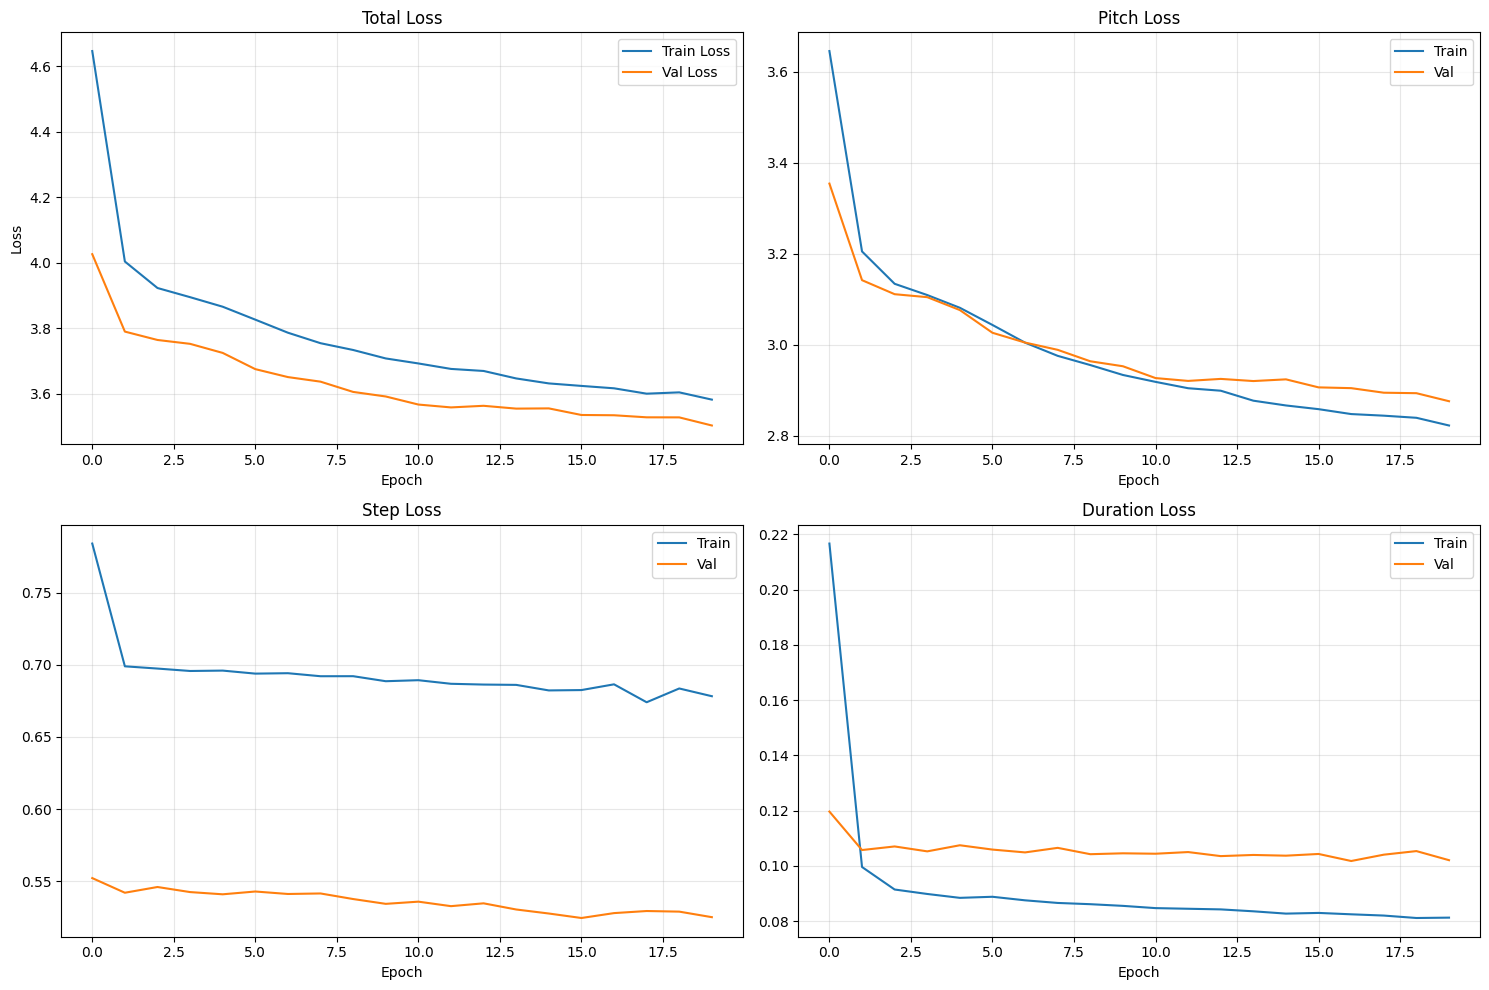

In [10]:
def plot_training_history(history):
    """Plot training metrics"""
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))

    # Total loss
    axes[0, 0].plot(history.history['loss'], label='Train Loss')
    axes[0, 0].plot(history.history['val_loss'], label='Val Loss')
    axes[0, 0].set_title('Total Loss')
    axes[0, 0].set_xlabel('Epoch')
    axes[0, 0].set_ylabel('Loss')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)

    # Pitch loss
    axes[0, 1].plot(history.history['pitch_loss'], label='Train')
    axes[0, 1].plot(history.history['val_pitch_loss'], label='Val')
    axes[0, 1].set_title('Pitch Loss')
    axes[0, 1].set_xlabel('Epoch')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)

    # Step loss
    axes[1, 0].plot(history.history['step_loss'], label='Train')
    axes[1, 0].plot(history.history['val_step_loss'], label='Val')
    axes[1, 0].set_title('Step Loss')
    axes[1, 0].set_xlabel('Epoch')
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)

    # Duration loss
    axes[1, 1].plot(history.history['duration_loss'], label='Train')
    axes[1, 1].plot(history.history['val_duration_loss'], label='Val')
    axes[1, 1].set_title('Duration Loss')
    axes[1, 1].set_xlabel('Epoch')
    axes[1, 1].legend()
    axes[1, 1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig(config.OUTPUT_DIR / 'training_history.png', dpi=150)
    plt.show()

plot_training_history(history)

## 11. Music Generation

This section implements the inference pipeline for generating novel musical sequences using the trained model.

### Generation Process

1. **Seed Selection**: 
   - Randomly selects a `SEQ_LENGTH`-sized window from the training data as the initial seed
   - This seed provides the musical context for the first prediction

2. **Iterative Prediction**:
   - The model predicts the next note's pitch, step, and duration
   - The predicted note is appended to the sequence
   - The input window slides forward (removing the oldest note, adding the new prediction)
   - This process repeats for `NUM_PREDICTIONS` iterations

3. **Temperature Sampling**:
   - **Pitch Prediction**: Uses temperature-scaled categorical sampling
     - Temperature > 1.0: More diverse, creative outputs (higher entropy)
     - Temperature < 1.0: More conservative, predictable outputs (lower entropy)
     - Default: 1.2 for balanced creativity and coherence
   - **Step/Duration**: Direct regression outputs (no sampling)

4. **Constraint Enforcement**:
   - Ensures step and duration values are non-negative
   - Maintains temporal consistency by accumulating step values

### Key Functions

- **`predict_next_note`**: Performs single-step prediction with temperature sampling
- **`generate_melody`**: Orchestrates the full generation process, producing a complete musical sequence

**Output Format**: Returns a DataFrame with columns `[pitch, start, end, step, duration]` representing the generated melody.

In [11]:
def predict_next_note(
    notes: np.ndarray,
    model: keras.Model,
    temperature: float = 1.0
) -> Tuple[int, float, float]:
    """
    Predict next note with temperature sampling

    Returns:
        (pitch, step, duration)
    """
    assert temperature > 0, "Temperature must be positive"

    predictions = model.predict(notes, verbose=0)

    # Pitch sampling with temperature
    pitch_logits = predictions['pitch'] / temperature
    pitch = tf.random.categorical(pitch_logits, num_samples=1)
    pitch = tf.squeeze(pitch, axis=-1).numpy()[0]

    # Regression outputs
    step = tf.squeeze(predictions['step'], axis=-1).numpy()[0]
    duration = tf.squeeze(predictions['duration'], axis=-1).numpy()[0]

    # Ensure positive values
    step = max(0, step)
    duration = max(0, duration)

    return int(pitch), float(step), float(duration)


def generate_melody(
    model: keras.Model,
    seed_notes: np.ndarray,
    num_predictions: int = config.NUM_PREDICTIONS,
    temperature: float = config.TEMPERATURE
) -> pd.DataFrame:
    """
    Generate melody with optimized inference
    """
    # Prepare seed sequence
    start_idx = np.random.randint(0, len(seed_notes) - config.SEQ_LENGTH)
    input_notes = seed_notes[start_idx:start_idx + config.SEQ_LENGTH] / np.array(
        [config.VOCAB_SIZE, MAX_STEP, MAX_DURATION]
    )

    generated_notes = []
    prev_start = 0

    print("Generating melody...")
    for i in tqdm(range(num_predictions), desc="Generating notes"):
        pitch, step, duration = predict_next_note(
            input_notes[np.newaxis, :, :],
            model,
            temperature
        )

        start = prev_start + step
        end = start + duration

        generated_notes.append({
            'pitch': pitch,
            'start': start,
            'end': end,
            'step': step,
            'duration': duration
        })

        # Update input sequence
        new_note = [pitch / config.VOCAB_SIZE, step / MAX_STEP, duration / MAX_DURATION]
        input_notes = np.vstack([input_notes[1:], new_note])
        prev_start = start

    return pd.DataFrame(generated_notes)


# Generate melody
sample_notes = np.stack([all_notes_df[key] for key in MIDIProcessor.KEY_ORDER], axis=1)
generated_notes_df = generate_melody(model, sample_notes)

print(f"\n✓ Generated {len(generated_notes_df)} notes")
print(generated_notes_df.head())

Generating melody...


Generating notes:   0%|          | 0/120 [00:00<?, ?it/s]


✓ Generated 120 notes
   pitch     start       end      step  duration
0     79  0.125841  0.292326  0.125841  0.166485
1     82  0.249546  0.421289  0.123705  0.171743
2     72  0.385321  0.563614  0.135775  0.178293
3     79  0.571953  0.761355  0.186632  0.189402
4     84  0.702738  0.881084  0.130784  0.178346


## 12. Visualization of Generated Music

The piano roll visualization provides an intuitive graphical representation of the generated melody, enabling visual assessment of musical quality and structure.

### Piano Roll Representation

The `plot_piano_roll` function creates a time-pitch plot where:
- **X-axis**: Time in seconds (from note start to end)
- **Y-axis**: MIDI pitch values (0-127, representing musical notes)
- **Lines**: Horizontal segments connecting note start and end times at their respective pitches

### Visual Analysis

This visualization helps assess:
- **Pitch Range**: Whether the generated melody uses an appropriate range of notes
- **Rhythmic Patterns**: The timing and spacing of notes (visible as gaps and clusters)
- **Musical Coherence**: Whether the melody follows logical musical progressions
- **Note Duration**: Longer notes appear as longer horizontal segments

**Interpretation Guidelines:**
- Smooth, connected lines suggest coherent melodic flow
- Appropriate pitch variation indicates musical interest
- Regular spacing suggests consistent rhythm
- Clusters of notes may indicate chord-like structures or rapid passages

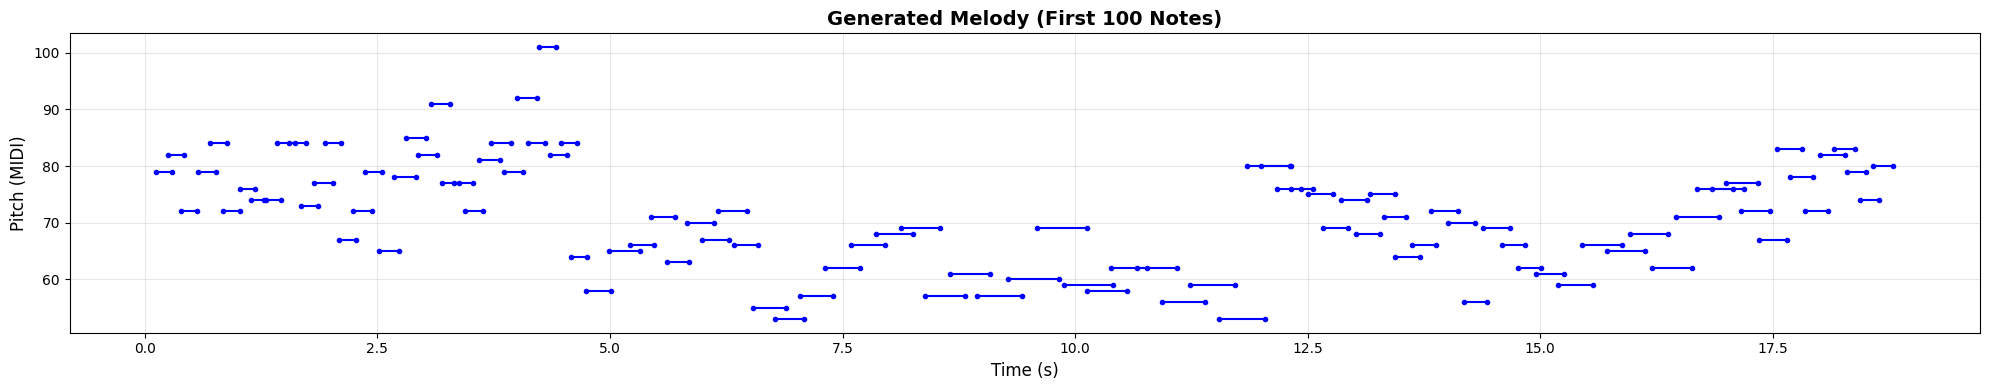

In [12]:
def plot_piano_roll(notes: pd.DataFrame, title: str = "Generated Melody"):
    """Visualize piano roll"""
    plt.figure(figsize=(20, 4))

    plot_pitch = np.stack([notes['pitch'], notes['pitch']], axis=0)
    plot_start_stop = np.stack([notes['start'], notes['end']], axis=0)

    plt.plot(plot_start_stop, plot_pitch, color="b", marker=".", linewidth=1.5)
    plt.xlabel('Time (s)', fontsize=12)
    plt.ylabel('Pitch (MIDI)', fontsize=12)
    plt.title(title, fontsize=14, fontweight='bold')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig(config.OUTPUT_DIR / 'piano_roll.png', dpi=150)
    plt.show()

# Visualize
plot_piano_roll(generated_notes_df.head(100), "Generated Melody (First 100 Notes)")

## 13. Export to MIDI

This section converts the generated note sequence back into a standard MIDI file format, enabling playback, analysis, and further processing.

### MIDI Conversion Process

The `notes_to_midi` function reconstructs a MIDI file by:
1. **Creating MIDI Structure**: Initializes a `PrettyMIDI` object with a specified instrument (default: Acoustic Grand Piano)
2. **Temporal Reconstruction**: Converts relative timing (step values) back to absolute timing by accumulating step intervals
3. **Note Creation**: Generates MIDI note events with:
   - **Pitch**: The predicted MIDI note number
   - **Start/End Times**: Calculated from accumulated step and duration values
   - **Velocity**: Fixed at 80 (moderate volume)

### File Output

- **Format**: Standard MIDI file (`.mid`)
- **Naming**: Timestamped filename for unique identification
- **Location**: Saved to the `output/` directory
- **Compatibility**: Can be opened in any MIDI-compatible software:
  - Media players (VLC, Windows Media Player)
  - Digital Audio Workstations (DAW) like GarageBand, FL Studio, Ableton
  - Music notation software (MuseScore, Sibelius)
  - Online MIDI players

**Use Cases**: The exported MIDI file enables further musical analysis, editing, arrangement, or integration into larger compositions.

In [13]:
# Convert to MIDI and save
output_pm = MIDIProcessor.notes_to_midi(
    generated_notes_df,
    instrument_name='Acoustic Grand Piano',
    velocity=80
)

timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
output_file = config.OUTPUT_DIR / f'generated_melody_{timestamp}.mid'
output_pm.write(str(output_file))

print(f"\n✓ MIDI file saved: {output_file}")


✓ MIDI file saved: output/generated_melody_20251216_020028.mid


## 14. Model Serialization

This section saves the trained model and all associated parameters required for future inference, enabling model reuse without retraining.

### Saved Components

1. **Model Architecture and Weights**:
   - Saved in Keras native format (`.keras`)
   - Includes complete model architecture, trained weights, and compilation configuration
   - Can be reloaded with `keras.models.load_model()`

2. **Normalization Parameters**:
   - Saved as JSON file for easy access
   - Contains: `MAX_STEP`, `MAX_DURATION`, `VOCAB_SIZE`, `SEQ_LENGTH`
   - **Critical**: These values must match training-time normalization for correct inference

### Model Persistence Benefits

- **Reproducibility**: Exact model state can be restored
- **Deployment**: Model can be loaded in production environments
- **Experimentation**: Multiple model versions can be saved and compared
- **Efficiency**: Eliminates need to retrain for generation tasks

**Loading Requirements**: When reloading the model, ensure:
- Same TensorFlow/Keras version (for compatibility)
- Normalization parameters are loaded and applied identically
- Input preprocessing matches training-time procedures

In [14]:
# Save model
final_model_path = config.MODEL_DIR / 'music_generator_final.keras'
model.save(str(final_model_path))

# Save normalization parameters
import json
norm_params = {
    'MAX_STEP': float(MAX_STEP),
    'MAX_DURATION': float(MAX_DURATION),
    'VOCAB_SIZE': config.VOCAB_SIZE,
    'SEQ_LENGTH': config.SEQ_LENGTH
}

with open(config.MODEL_DIR / 'normalization_params.json', 'w') as f:
    json.dump(norm_params, f, indent=2)

print(f"✓ Model saved to: {final_model_path}")
print(f"✓ Normalization params saved")

✓ Model saved to: models/music_generator_final.keras
✓ Normalization params saved


## 15. Conclusion and Future Work

### Project Summary

This project successfully implements an end-to-end pipeline for polyphonic music generation using LSTM neural networks. The system demonstrates the capability to learn musical patterns from classical MIDI compositions and generate novel melodies that maintain musical coherence.

### Key Achievements

1. **Architecture Design**: 
   - Multi-output LSTM architecture successfully predicts pitch, timing, and duration simultaneously
   - Layer Normalization and Dropout regularization ensure stable training

2. **Training Optimization**:
   - Mixed precision training accelerates training on compatible hardware
   - Learning rate scheduling and early stopping prevent overfitting
   - Comprehensive callback system provides detailed training monitoring

3. **Data Pipeline**:
   - Efficient data loading with caching reduces preprocessing overhead
   - Feature normalization ensures stable gradient flow
   - Sliding window sequence construction maximizes data utilization

4. **Code Quality**:
   - Modular design with clear separation of concerns
   - Type hints and documentation enhance maintainability
   - Robust error handling ensures graceful failure recovery

### Technical Insights

- **Sequence Modeling**: LSTM networks effectively capture temporal dependencies in musical sequences
- **Multi-Task Learning**: Joint prediction of pitch, step, and duration enables coherent musical generation
- **Temperature Sampling**: Provides a mechanism to balance creativity and musical coherence

### Future Improvements

1. **Architecture Enhancements**:
   - **Transformer Models**: Explore attention mechanisms for better long-range dependency modeling
   - **Variational Autoencoders**: Enable style control and interpolation in latent space
   - **GAN-based Approaches**: Adversarial training for more realistic musical generation

2. **Multi-Track Generation**:
   - Extend to polyphonic music with multiple simultaneous voices
   - Generate accompaniment (chords, bass lines, drums) alongside melodies
   - Implement hierarchical models for multi-scale musical structure

3. **Advanced Features**:
   - **Style Transfer**: Generate music in specific styles or genres
   - **Conditional Generation**: Control generation based on user-specified attributes (tempo, key, mood)
   - **Interactive Generation**: Real-time music generation with user feedback

4. **Data and Augmentation**:
   - Expand dataset to include diverse musical genres
   - Implement data augmentation techniques (transposition, tempo variation)
   - Explore transfer learning from pre-trained models

5. **Evaluation Metrics**:
   - Develop quantitative metrics for musical quality assessment
   - Implement human evaluation studies
   - Analyze generated music for harmonic and rhythmic coherence

---
